# 从 _info_eef_right 计算 Action

这个 notebook 用于从 `_info_eef_right` topic 中计算 action。

## 目标
- 从 `_info_eef_right` 提取 position (xyz) 和 orientation (四元数)
- 处理 NaN 值（第一个和最后一个如果有 NaN，和上一个/下一个状态保持一致）
- 计算 action：前后两个状态的差值
  - 前 3 维：xyz 位移 (position delta)
  - 后 3 维：轴角 (axis-angle delta，从四元数转换并使用相对旋转计算)
- 183 个数据 → 182 个 action（最后一个 action 为全 0，表示不动）


In [1]:
import h5py
import numpy as np
from pathlib import Path
from scipy.spatial.transform import Rotation as R

# 设置文件路径
hdf5_path = Path("pick_blue_bottle/rosbag2_2026_01_09-21_24_48/rosbag2_2026_01_09-21_24_48_0.h5")

print(f"📁 文件路径: {hdf5_path}")
print(f"📊 文件是否存在: {hdf5_path.exists()}")

if hdf5_path.exists():
    file_size = hdf5_path.stat().st_size / (1024 * 1024)  # MB
    print(f"📦 文件大小: {file_size:.2f} MB")

# 定义工具函数
def axisangle_to_quat(axis_angle):
    """
    axis_angle: (3,)
    return quat: (4,) in xyzw
    """
    return R.from_rotvec(axis_angle).as_quat()

def quat_to_axisangle(quat):
    """
    quat: (4,) xyzw
    return axis-angle: (3,)
    """
    return R.from_quat(quat).as_rotvec()

def relative_axisangle(aa_t, aa_t1):
    """
    Compute relative rotation from t -> t+1 in axis-angle
    """
    q_t = axisangle_to_quat(aa_t)
    q_t1 = axisangle_to_quat(aa_t1)

    # relative rotation: q_rel = q_t1 * inverse(q_t)
    q_rel = R.from_quat(q_t1) * R.from_quat(q_t).inv()
    return q_rel.as_rotvec()

def compute_geom_action(
    ee_pos_t,
    ee_ori_t,
    ee_pos_t1,
    ee_ori_t1,
):
    """
    All inputs are np.ndarray with shape (3,)
    ee_ori_* are axis-angle
    """
    delta_pos = ee_pos_t1 - ee_pos_t
    delta_ori = relative_axisangle(ee_ori_t, ee_ori_t1)

    action_6d = np.concatenate([delta_pos, delta_ori])
    return action_6d


📁 文件路径: pick_blue_bottle/rosbag2_2026_01_09-21_24_48/rosbag2_2026_01_09-21_24_48_0.h5
📊 文件是否存在: True
📦 文件大小: 8.91 MB


## 1. 读取 _info_eef_right 数据

In [2]:
# 读取 _info_eef_right 数据
print("=" * 80)
print("📊 读取 _info_eef_right 数据")
print("=" * 80)

with h5py.File(hdf5_path, 'r') as f:
    if 'topics' in f and '_info_eef_right' in f['topics']:
        eef_right_group = f['topics']['_info_eef_right']
        
        # 读取 position 和 orientation
        position = eef_right_group['position'][:]  # (183, 3)
        orientation = eef_right_group['orientation'][:]  # (183, 4) - 四元数 [x, y, z, w]
        
        print(f"\n✅ 读取成功！")
        print(f"  Position shape: {position.shape}, dtype: {position.dtype}")
        print(f"  Orientation shape: {orientation.shape}, dtype: {orientation.dtype}")
        
        # 显示前几个和后几个数据
        print(f"\n前 5 个 position:")
        print(position[:5])
        print(f"\n后 5 个 position:")
        print(position[-5:])
        
        print(f"\n前 5 个 orientation (四元数):")
        print(orientation[:5])
        print(f"\n后 5 个 orientation (四元数):")
        print(orientation[-5:])
        
        # 检查 NaN
        position_nan_count = np.isnan(position).sum()
        orientation_nan_count = np.isnan(orientation).sum()
        print(f"\n📊 NaN 统计:")
        print(f"  Position NaN 数量: {position_nan_count}")
        print(f"  Orientation NaN 数量: {orientation_nan_count}")
        
        # 检查哪些行有 NaN
        position_has_nan = np.isnan(position).any(axis=1)
        orientation_has_nan = np.isnan(orientation).any(axis=1)
        nan_rows = np.where(position_has_nan | orientation_has_nan)[0]
        if len(nan_rows) > 0:
            print(f"  包含 NaN 的行索引: {nan_rows}")
    else:
        print("❌ 未找到 _info_eef_right")
        position = None
        orientation = None


📊 读取 _info_eef_right 数据

✅ 读取成功！
  Position shape: (183, 3), dtype: float64
  Orientation shape: (183, 4), dtype: float64

前 5 个 position:
[[        nan         nan         nan]
 [ 0.30545341 -0.24591602 -0.00465428]
 [ 0.30839172 -0.24355913 -0.00458519]
 [ 0.31205644 -0.24101822 -0.00435647]
 [ 0.31476325 -0.23933411 -0.00382199]]

后 5 个 position:
[[ 0.38374988 -0.12846304  0.05938183]
 [ 0.38005646 -0.14028774  0.05989933]
 [ 0.37555084 -0.15366904  0.06040785]
 [ 0.36757348 -0.17563888  0.06065904]
 [ 0.36125823 -0.19145483  0.06021444]]

前 5 个 orientation (四元数):
[[        nan         nan         nan         nan]
 [ 0.81909586 -0.04470617  0.56915985  0.05603919]
 [ 0.81921795 -0.04208422  0.56929035  0.05494872]
 [ 0.81916204 -0.039132    0.56967945  0.0539219 ]
 [ 0.81880775 -0.03745558  0.57038806  0.05299448]]

后 5 个 orientation (四元数):
[[ 0.78609275  0.00540568  0.61576621 -0.0534878 ]
 [ 0.78547454 -0.00183245  0.61705324 -0.0476623 ]
 [ 0.78471245 -0.01005875  0.61840363 -0.0

## 1.5. 打印 _info_eef_right 的完整数据


In [ ]:
# 打印 _info_eef_right 的完整数据
print("=" * 80)
print("📋 _info_eef_right 完整数据")
print("=" * 80)

if position is not None and orientation is not None:
    print(f"\n数据形状:")
    print(f"  Position: {position.shape}")
    print(f"  Orientation: {orientation.shape}")
    
    print(f"\n所有 Position 数据 (共 {len(position)} 个):")
    print("索引 |      x (m)    |      y (m)    |      z (m)    ")
    print("-" * 60)
    for i in range(len(position)):
        pos = position[i]
        if np.isnan(pos).any():
            print(f"{i:5d} | {'NaN':>14} | {'NaN':>14} | {'NaN':>14}")
        else:
            print(f"{i:5d} | {pos[0]:14.6f} | {pos[1]:14.6f} | {pos[2]:14.6f}")
    
    print(f"\n所有 Orientation 数据 (四元数 [x, y, z, w]，共 {len(orientation)} 个):")
    print("索引 |      qx       |      qy       |      qz       |      qw       ")
    print("-" * 75)
    for i in range(len(orientation)):
        ori = orientation[i]
        if np.isnan(ori).any():
            print(f"{i:5d} | {'NaN':>14} | {'NaN':>14} | {'NaN':>14} | {'NaN':>14}")
        else:
            print(f"{i:5d} | {ori[0]:14.6f} | {ori[1]:14.6f} | {ori[2]:14.6f} | {ori[3]:14.6f}")
    
    # 统计信息
    print(f"\n" + "=" * 80)
    print("📊 统计信息")
    print("=" * 80)
    
    # Position 统计（排除 NaN）
    valid_positions = position[~np.isnan(position).any(axis=1)]
    if len(valid_positions) > 0:
        print(f"\nPosition 统计 (有效数据: {len(valid_positions)}/{len(position)}):")
        print(f"  x: Min={valid_positions[:, 0].min():.6f}, Max={valid_positions[:, 0].max():.6f}, Mean={valid_positions[:, 0].mean():.6f}, Std={valid_positions[:, 0].std():.6f}")
        print(f"  y: Min={valid_positions[:, 1].min():.6f}, Max={valid_positions[:, 1].max():.6f}, Mean={valid_positions[:, 1].mean():.6f}, Std={valid_positions[:, 1].std():.6f}")
        print(f"  z: Min={valid_positions[:, 2].min():.6f}, Max={valid_positions[:, 2].max():.6f}, Mean={valid_positions[:, 2].mean():.6f}, Std={valid_positions[:, 2].std():.6f}")
    
    # Orientation 统计（排除 NaN）
    valid_orientations = orientation[~np.isnan(orientation).any(axis=1)]
    if len(valid_orientations) > 0:
        print(f"\nOrientation 统计 (有效数据: {len(valid_orientations)}/{len(orientation)}):")
        print(f"  qx: Min={valid_orientations[:, 0].min():.6f}, Max={valid_orientations[:, 0].max():.6f}, Mean={valid_orientations[:, 0].mean():.6f}, Std={valid_orientations[:, 0].std():.6f}")
        print(f"  qy: Min={valid_orientations[:, 1].min():.6f}, Max={valid_orientations[:, 1].max():.6f}, Mean={valid_orientations[:, 1].mean():.6f}, Std={valid_orientations[:, 1].std():.6f}")
        print(f"  qz: Min={valid_orientations[:, 2].min():.6f}, Max={valid_orientations[:, 2].max():.6f}, Mean={valid_orientations[:, 2].mean():.6f}, Std={valid_orientations[:, 2].std():.6f}")
        print(f"  qw: Min={valid_orientations[:, 3].min():.6f}, Max={valid_orientations[:, 3].max():.6f}, Mean={valid_orientations[:, 3].mean():.6f}, Std={valid_orientations[:, 3].std():.6f}")
        
        # 检查四元数范数（应该是 1）
        quat_norms = np.linalg.norm(valid_orientations, axis=1)
        print(f"  四元数范数范围: [{quat_norms.min():.6f}, {quat_norms.max():.6f}] (应该接近 1.0)")
else:
    print("❌ 数据未加载")


## 2. 处理 NaN 值

In [3]:
# 处理 NaN 值
print("=" * 80)
print("🔧 处理 NaN 值")
print("=" * 80)

if position is not None and orientation is not None:
    # 复制数据
    position_clean = position.copy()
    orientation_clean = orientation.copy()
    
    # 处理 position 的 NaN
    for i in range(len(position_clean)):
        if np.isnan(position_clean[i]).any():
            if i == 0:
                # 第一个：使用下一个非 NaN 值
                for j in range(1, len(position_clean)):
                    if not np.isnan(position_clean[j]).any():
                        position_clean[i] = position_clean[j]
                        print(f"  行 {i}: position NaN，使用行 {j} 的值")
                        break
            elif i == len(position_clean) - 1:
                # 最后一个：使用上一个非 NaN 值
                for j in range(len(position_clean) - 2, -1, -1):
                    if not np.isnan(position_clean[j]).any():
                        position_clean[i] = position_clean[j]
                        print(f"  行 {i}: position NaN，使用行 {j} 的值")
                        break
            else:
                # 中间：使用前一个非 NaN 值
                for j in range(i - 1, -1, -1):
                    if not np.isnan(position_clean[j]).any():
                        position_clean[i] = position_clean[j]
                        print(f"  行 {i}: position NaN，使用行 {j} 的值")
                        break
    
    # 处理 orientation 的 NaN
    for i in range(len(orientation_clean)):
        if np.isnan(orientation_clean[i]).any():
            if i == 0:
                # 第一个：使用下一个非 NaN 值
                for j in range(1, len(orientation_clean)):
                    if not np.isnan(orientation_clean[j]).any():
                        orientation_clean[i] = orientation_clean[j]
                        print(f"  行 {i}: orientation NaN，使用行 {j} 的值")
                        break
            elif i == len(orientation_clean) - 1:
                # 最后一个：使用上一个非 NaN 值
                for j in range(len(orientation_clean) - 2, -1, -1):
                    if not np.isnan(orientation_clean[j]).any():
                        orientation_clean[i] = orientation_clean[j]
                        print(f"  行 {i}: orientation NaN，使用行 {j} 的值")
                        break
            else:
                # 中间：使用前一个非 NaN 值
                for j in range(i - 1, -1, -1):
                    if not np.isnan(orientation_clean[j]).any():
                        orientation_clean[i] = orientation_clean[j]
                        print(f"  行 {i}: orientation NaN，使用行 {j} 的值")
                        break
    
    # 验证是否还有 NaN
    position_nan_after = np.isnan(position_clean).sum()
    orientation_nan_after = np.isnan(orientation_clean).sum()
    print(f"\n✅ 处理完成！")
    print(f"  Position NaN 数量（处理后）: {position_nan_after}")
    print(f"  Orientation NaN 数量（处理后）: {orientation_nan_after}")
    
    if position_nan_after == 0 and orientation_nan_after == 0:
        print("  ✅ 所有 NaN 已处理")
    else:
        print("  ⚠️  仍有 NaN 存在")


🔧 处理 NaN 值
  行 0: position NaN，使用行 1 的值
  行 0: orientation NaN，使用行 1 的值

✅ 处理完成！
  Position NaN 数量（处理后）: 0
  Orientation NaN 数量（处理后）: 0
  ✅ 所有 NaN 已处理


In [4]:
# 将四元数转换为轴角 (Axis-Angle)
print("=" * 80)
print("🔄 将四元数转换为轴角 (Axis-Angle)")
print("=" * 80)

if position_clean is not None and orientation_clean is not None:
    # 四元数格式：ROS 标准是 [x, y, z, w]
    # scipy 的 Rotation.from_quat 需要 [x, y, z, w] 格式（与 ROS 一致）
    # 所以可以直接使用
    
    # 转换为轴角
    axis_angles = np.zeros((len(orientation_clean), 3))
    for i in range(len(orientation_clean)):
        quat = orientation_clean[i]  # [x, y, z, w]
        axis_angles[i] = quat_to_axisangle(quat)
    
    print(f"\n✅ 转换完成！")
    print(f"  轴角 shape: {axis_angles.shape}")
    print(f"  前 5 个轴角 (弧度):")
    print(axis_angles[:5])
    print(f"  后 5 个轴角 (弧度):")
    print(axis_angles[-5:])
    
    # 显示范围
    print(f"\n📊 轴角统计:")
    print(f"  rx 范围: [{axis_angles[:, 0].min():.6f}, {axis_angles[:, 0].max():.6f}]")
    print(f"  ry 范围: [{axis_angles[:, 1].min():.6f}, {axis_angles[:, 1].max():.6f}]")
    print(f"  rz 范围: [{axis_angles[:, 2].min():.6f}, {axis_angles[:, 2].max():.6f}]")
    
    # 显示轴角的模长（旋转角度）
    axis_angle_norms = np.linalg.norm(axis_angles, axis=1)
    print(f"  轴角模长范围: [{axis_angle_norms.min():.6f}, {axis_angle_norms.max():.6f}] (弧度)")
    print(f"  轴角模长范围: [{np.degrees(axis_angle_norms.min()):.2f}, {np.degrees(axis_angle_norms.max()):.2f}] (度)")


🔄 将四元数转换为轴角 (Axis-Angle)

✅ 转换完成！
  轴角 shape: (183, 3)
  前 5 个轴角 (弧度):
[[ 2.48532001 -0.13564851  1.72695824]
 [ 2.48532001 -0.13564851  1.72695824]
 [ 2.48733169 -0.12777726  1.72849476]
 [ 2.48870971 -0.11888757  1.73075253]
 [ 2.48903273 -0.11385842  1.73388019]]
  后 5 个轴角 (弧度):
[[-2.38886997 -0.0164274  -1.8712619 ]
 [-2.39546004  0.00558841 -1.88182596]
 [-2.40252405  0.0307965  -1.8933427 ]
 [-2.417897    0.06904723 -1.91713147]
 [-2.43247073  0.09227124 -1.93851967]]

📊 轴角统计:
  rx 范围: [-2.616598, 2.644979]
  ry 范围: [-0.512023, 0.114742]
  rz 范围: [-1.938520, 1.747077]
  轴角模长范围: [2.895163, 3.141522] (弧度)
  轴角模长范围: [165.88, 180.00] (度)


## 4. 计算 Action（位移和轴角相对旋转）


In [5]:
# 计算 Action
print("=" * 80)
print("⚙️  计算 Action（使用相对旋转）")
print("=" * 80)

if position_clean is not None and axis_angles is not None:
    # 使用 compute_geom_action 函数计算每个 action
    # 183 个状态 → 182 个 action
    actions = np.zeros((182, 6))
    
    for i in range(182):
        ee_pos_t = position_clean[i]
        ee_ori_t = axis_angles[i]
        ee_pos_t1 = position_clean[i + 1]
        ee_ori_t1 = axis_angles[i + 1]
        
        action_6d = compute_geom_action(ee_pos_t, ee_ori_t, ee_pos_t1, ee_ori_t1)
        actions[i] = action_6d
    
    # 最后一个 action 应该是全 0（不动）
    # 确保最后一个 action 是 0（因为最后一个状态后没有下一个状态，所以应该不动）
    actions[-1] = 0.0
    
    print(f"\n✅ Action 计算完成！")
    print(f"  Action shape: {actions.shape}")
    print(f"  前 5 个 action:")
    print(actions[:5])
    print(f"  后 5 个 action:")
    print(actions[-5:])
    
    # 统计信息
    print(f"\n📊 Action 统计:")
    print(f"  Position delta (前 3 维):")
    print(f"    x 范围: [{actions[:, 0].min():.6f}, {actions[:, 0].max():.6f}], 均值: {actions[:, 0].mean():.6f}")
    print(f"    y 范围: [{actions[:, 1].min():.6f}, {actions[:, 1].max():.6f}], 均值: {actions[:, 1].mean():.6f}")
    print(f"    z 范围: [{actions[:, 2].min():.6f}, {actions[:, 2].max():.6f}], 均值: {actions[:, 2].mean():.6f}")
    print(f"  Axis-angle delta (后 3 维，相对旋转):")
    print(f"    rx 范围: [{actions[:, 3].min():.6f}, {actions[:, 3].max():.6f}], 均值: {actions[:, 3].mean():.6f}")
    print(f"    ry 范围: [{actions[:, 4].min():.6f}, {actions[:, 4].max():.6f}], 均值: {actions[:, 4].mean():.6f}")
    print(f"    rz 范围: [{actions[:, 5].min():.6f}, {actions[:, 5].max():.6f}], 均值: {actions[:, 5].mean():.6f}")
    
    # 显示轴角 delta 的模长（旋转角度）
    axis_angle_delta_norms = np.linalg.norm(actions[:, 3:6], axis=1)
    print(f"  轴角 delta 模长范围: [{axis_angle_delta_norms.min():.6f}, {axis_angle_delta_norms.max():.6f}] (弧度)")
    print(f"  轴角 delta 模长范围: [{np.degrees(axis_angle_delta_norms.min()):.2f}, {np.degrees(axis_angle_delta_norms.max()):.2f}] (度)")
    
    # 检查最后一个 action 是否接近 0
    last_action = actions[-1]
    print(f"\n📌 最后一个 action: {last_action}")
    print(f"  是否接近 0: {np.allclose(last_action, 0, atol=1e-6)}")


⚙️  计算 Action（使用相对旋转）

✅ Action 计算完成！
  Action shape: (182, 6)
  前 5 个 action:
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.93831785e-03  2.35689058e-03  6.90895306e-05 -1.19619901e-03
   1.21542598e-04  5.56210071e-03]
 [ 3.66471690e-03  2.54090422e-03  2.28726511e-04 -1.71786934e-03
  -4.63154813e-04  6.04420808e-03]
 [ 2.70681015e-03  1.68411428e-03  5.34477896e-04 -4.84301925e-04
  -1.45638309e-03  3.85188067e-03]
 [ 2.41886501e-03  1.22429659e-03  1.05201589e-03  1.06348454e-04
  -2.93982878e-03  2.57758403e-03]]
  后 5 个 action:
[[-0.00115826 -0.00375956  0.0001809  -0.00014121 -0.00067442 -0.00585582]
 [-0.00369341 -0.0118247   0.0005175  -0.00016474 -0.00207351 -0.01868524]
 [-0.00450562 -0.01338131  0.00050852  0.0001577  -0.00225429 -0.02095963]
 [-0.00797735 -0.02196984  0.00025119 -0.00621058 -0.00464303 -0.03650294]
 [ 0.          0.          0.          0.          0.          0.        ]]

📊 Action 统计:
  Positio

In [6]:
# 保存 Action 数据
print("=" * 80)
print("💾 保存 Action 数据")
print("=" * 80)

if 'actions' in locals():
    # 保存为 .npy 文件
    output_npy = Path("eef_right_actions.npy")
    np.save(output_npy, actions)
    print(f"\n✅ 已保存到: {output_npy}")
    print(f"   Shape: {actions.shape}")
    print(f"   Dtype: {actions.dtype}")
    
    # 保存为 .txt 文件（便于查看）
    output_txt = Path("eef_right_actions.txt")
    with open(output_txt, 'w', encoding='utf-8') as f:
        f.write("=" * 80 + "\n")
        f.write("Action 数据（从 _info_eef_right 计算）\n")
        f.write("=" * 80 + "\n\n")
        f.write(f"文件来源: {hdf5_path}\n")
        f.write(f"Action shape: {actions.shape}\n")
        f.write(f"Action dtype: {actions.dtype}\n")
        f.write(f"格式: [dx, dy, dz, drx, dry, drz]\n")
        f.write(f"  - dx, dy, dz: position delta (m)\n")
        f.write(f"  - drx, dry, drz: axis-angle delta (rad, 相对旋转)\n\n")
        
        f.write("=" * 80 + "\n")
        f.write("所有 Action 数据\n")
        f.write("=" * 80 + "\n")
        f.write("索引 |      dx      |      dy      |      dz      |      drx     |      dry     |      drz     \n")
        f.write("-" * 80 + "\n")
        for i in range(len(actions)):
            f.write(f"{i:5d} | {actions[i, 0]:12.6f} | {actions[i, 1]:12.6f} | {actions[i, 2]:12.6f} | "
                   f"{actions[i, 3]:12.6f} | {actions[i, 4]:12.6f} | {actions[i, 5]:12.6f}\n")
        
        f.write("\n" + "=" * 80 + "\n")
        f.write("统计信息\n")
        f.write("=" * 80 + "\n")
        f.write(f"dx:  Min={actions[:, 0].min():.6f}, Max={actions[:, 0].max():.6f}, Mean={actions[:, 0].mean():.6f}, Std={actions[:, 0].std():.6f}\n")
        f.write(f"dy:  Min={actions[:, 1].min():.6f}, Max={actions[:, 1].max():.6f}, Mean={actions[:, 1].mean():.6f}, Std={actions[:, 1].std():.6f}\n")
        f.write(f"dz:  Min={actions[:, 2].min():.6f}, Max={actions[:, 2].max():.6f}, Mean={actions[:, 2].mean():.6f}, Std={actions[:, 2].std():.6f}\n")
        f.write(f"drx: Min={actions[:, 3].min():.6f}, Max={actions[:, 3].max():.6f}, Mean={actions[:, 3].mean():.6f}, Std={actions[:, 3].std():.6f}\n")
        f.write(f"dry: Min={actions[:, 4].min():.6f}, Max={actions[:, 4].max():.6f}, Mean={actions[:, 4].mean():.6f}, Std={actions[:, 4].std():.6f}\n")
        f.write(f"drz: Min={actions[:, 5].min():.6f}, Max={actions[:, 5].max():.6f}, Mean={actions[:, 5].mean():.6f}, Std={actions[:, 5].std():.6f}\n")
    
    print(f"✅ 已保存到: {output_txt}")
    print(f"   文件大小: {output_txt.stat().st_size / 1024:.2f} KB")
    
    # 显示文件路径
    print(f"\n📁 输出文件:")
    print(f"  - {output_npy.absolute()}")
    print(f"  - {output_txt.absolute()}")


💾 保存 Action 数据

✅ 已保存到: eef_right_actions.npy
   Shape: (182, 6)
   Dtype: float64
✅ 已保存到: eef_right_actions.txt
   文件大小: 18.42 KB

📁 输出文件:
  - /home/wyz/openpi/eef_right_actions.npy
  - /home/wyz/openpi/eef_right_actions.txt


/tmp/ipykernel_1926026/1156697692.py:52: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1926026/1156697692.py:52: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1926026/1156697692.py:52: UserWarning: Glyph 21487 (\N{CJK UNIFIED IDEOGRAPH-53EF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1926026/1156697692.py:52: UserWarning: Glyph 35270 (\N{CJK UNIFIED IDEOGRAPH-89C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1926026/1156697692.py:52: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1926026/1156697692.py:53: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.savefig('eef_right_actions_plot.png', dpi=150, bbox_inches='tight')
/tmp/ipykernel_1926026/

✅ 已保存可视化图像: eef_right_actions_plot.png


/home/wyz/miniconda3/envs/pi0/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/wyz/miniconda3/envs/pi0/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/wyz/miniconda3/envs/pi0/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21487 (\N{CJK UNIFIED IDEOGRAPH-53EF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/wyz/miniconda3/envs/pi0/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35270 (\N{CJK UNIFIED IDEOGRAPH-89C6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/wyz/miniconda3/envs/pi0/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarni

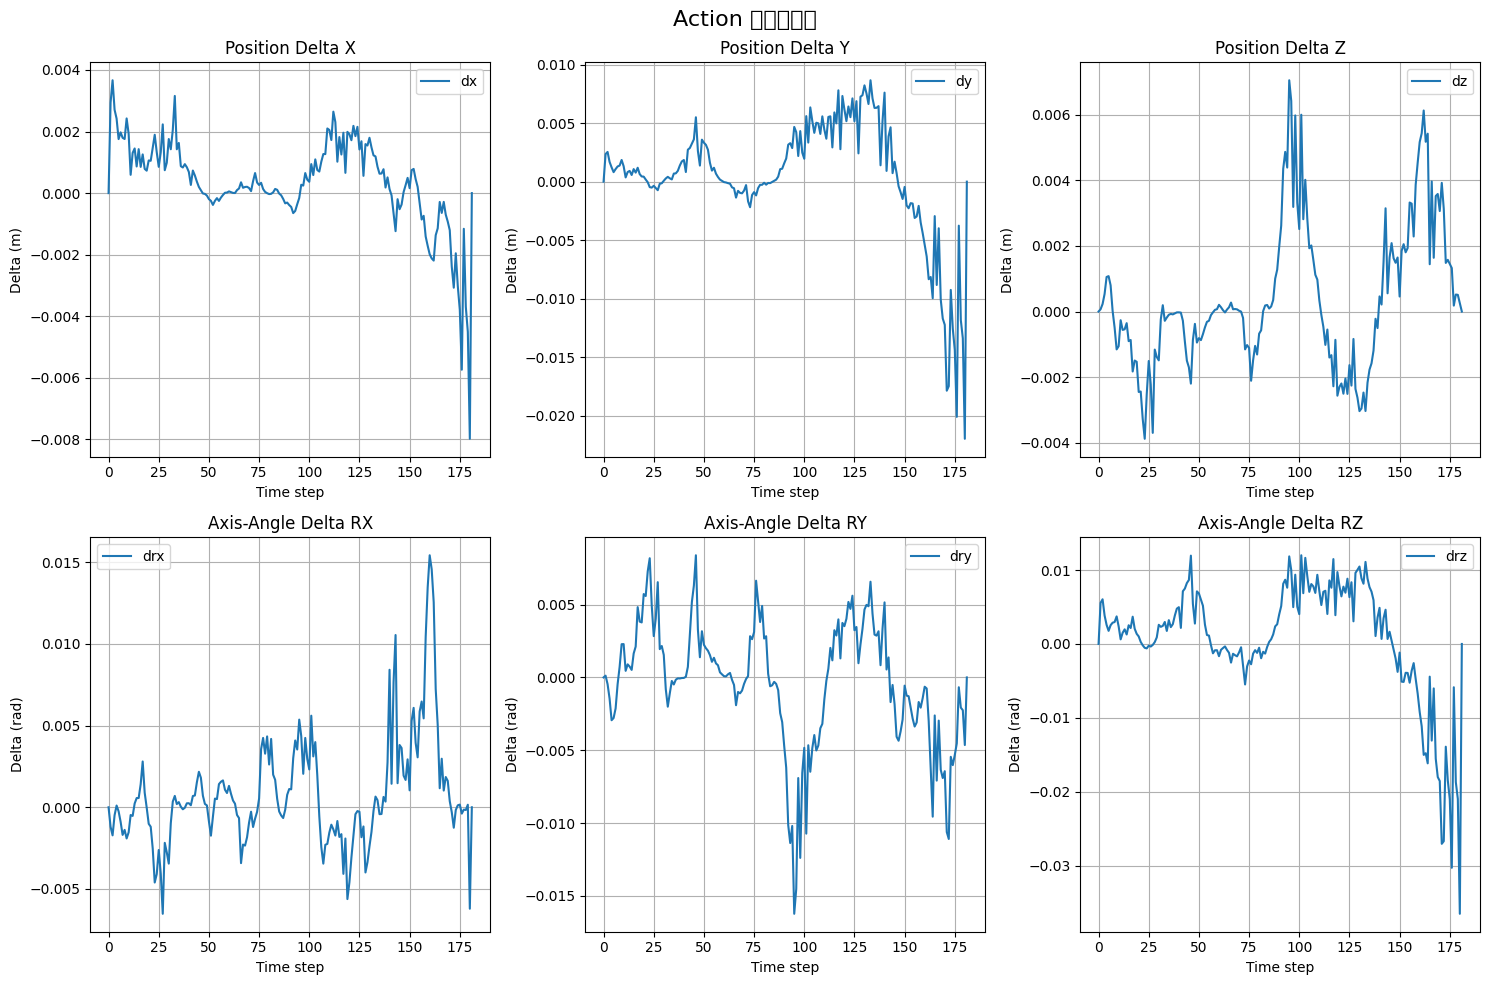

In [7]:
# 可视化 Action 数据
import matplotlib.pyplot as plt

if 'actions' in locals():
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Action 数据可视化', fontsize=16)
    
    # Position deltas
    axes[0, 0].plot(actions[:, 0], label='dx')
    axes[0, 0].set_title('Position Delta X')
    axes[0, 0].set_xlabel('Time step')
    axes[0, 0].set_ylabel('Delta (m)')
    axes[0, 0].grid(True)
    axes[0, 0].legend()
    
    axes[0, 1].plot(actions[:, 1], label='dy')
    axes[0, 1].set_title('Position Delta Y')
    axes[0, 1].set_xlabel('Time step')
    axes[0, 1].set_ylabel('Delta (m)')
    axes[0, 1].grid(True)
    axes[0, 1].legend()
    
    axes[0, 2].plot(actions[:, 2], label='dz')
    axes[0, 2].set_title('Position Delta Z')
    axes[0, 2].set_xlabel('Time step')
    axes[0, 2].set_ylabel('Delta (m)')
    axes[0, 2].grid(True)
    axes[0, 2].legend()
    
    # Axis-angle deltas
    axes[1, 0].plot(actions[:, 3], label='drx')
    axes[1, 0].set_title('Axis-Angle Delta RX')
    axes[1, 0].set_xlabel('Time step')
    axes[1, 0].set_ylabel('Delta (rad)')
    axes[1, 0].grid(True)
    axes[1, 0].legend()
    
    axes[1, 1].plot(actions[:, 4], label='dry')
    axes[1, 1].set_title('Axis-Angle Delta RY')
    axes[1, 1].set_xlabel('Time step')
    axes[1, 1].set_ylabel('Delta (rad)')
    axes[1, 1].grid(True)
    axes[1, 1].legend()
    
    axes[1, 2].plot(actions[:, 5], label='drz')
    axes[1, 2].set_title('Axis-Angle Delta RZ')
    axes[1, 2].set_xlabel('Time step')
    axes[1, 2].set_ylabel('Delta (rad)')
    axes[1, 2].grid(True)
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.savefig('eef_right_actions_plot.png', dpi=150, bbox_inches='tight')
    print("✅ 已保存可视化图像: eef_right_actions_plot.png")
    plt.show()
